# Beans

We are going to use a dataset that works with Beans https://www.tensorflow.org/datasets/catalog/beans

It has 3 classes, 2 diseased classes and one healthy class

(I was going to use Cats vs Dogs like keras does but that seems to have an error on current versions of Windows and I don't want to have to go around to everyone showing how to fix it!)

We are going to make use of a dataset from tensorflow https://www.tensorflow.org/datasets/catalog/overview

You will need to install tensorflow_datasets using pip (but you should've done this for a previous workbook anyway)

In [152]:
import tensorflow as tf

In [153]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Some datasets have separate train and test splits, horses_or_humans does, Beans does. Some sets like tf_flowers and cats_vs_dogs only have train so you have to manually separate test set - as always read the manual.

If this was a dataset we downloaded, this is easier with image_dataset_from_directory

In [154]:
train_ds, validation_ds, test_ds = tfds.load(
    "beans",
    split=['train','validation', 'test'],
    as_supervised=True  # Include labels
)

I didn't set anything about shuffling, hopefully they were already shuffled somewhat, let's make sure the first half are not all 1s and the second half are not all 0s

In [155]:
num_classes = 3

In [156]:
num_classes

3

In [157]:
y = [y for x, y in train_ds]

In [158]:
y

[<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64

In [159]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 1034
Number of validation samples: 133
Number of test samples: 128


Not a massive dataset let's go anyway

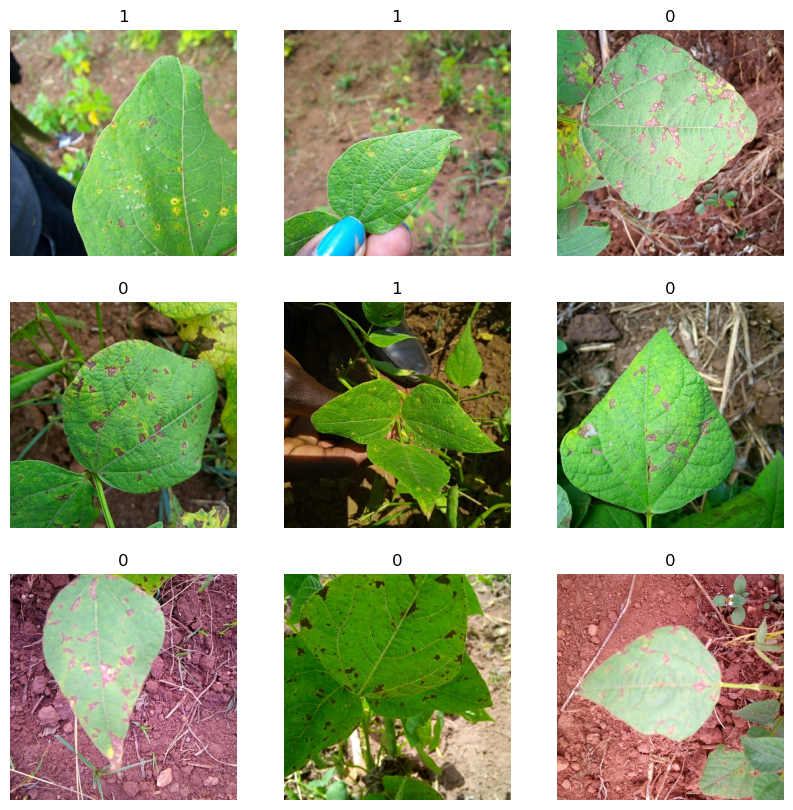

In [160]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## CNN From Scratch

We first of all need to pick an image size, let's go with 100x100 to start with).

We need to resize the images

In [161]:
resize_fn = tf.keras.layers.Resizing(100, 100)

In [162]:
train100_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation100_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test100_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

I'm keeping the original set sizes in case I want to change later

We need to set them up for batches

In [163]:
from tensorflow import data as tf_data

In [164]:
batch_size = 32
train100_ds = train100_ds.batch(batch_size)
validation100_ds = validation100_ds.batch(batch_size)
test100_ds = test100_ds.batch(batch_size)

In [165]:
from tensorflow.keras import layers

The output is going to be only 3 units

In [166]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(100, 100, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary(show_trainable=True)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ rescaling_20 (Rescaling)              │ (None, 100, 100, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ conv2d_60 (Conv2D)                    │ (None, 100, 100, 16)          │            448 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ max_pooling2d_60 (MaxPooling2D)       │ (None, 50, 50, 16)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ conv2d_61 (Conv2D)                    │ (None, 50, 50, 32)            │          4,640 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ max_pooling2d_61 (MaxPooling2D)       │ (None, 25, 25, 32)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ conv2d_62 (Conv2D)                    │ (None, 25, 25, 64)            │         18,496 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ max_pooling2d_62 (MaxPooling2D)       │ (None, 12, 12, 64)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ global_average_pooling2d_16           │ (None, 64)                    │              0 │    -    │
│ (GlobalAveragePooling2D)              │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_39 (Dense)                      │ (None, 128)                   │          8,320 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_40 (Dense)                      │ (None, 3)                     │            387 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 32,291 (126.14 KB)

 Trainable params: 32,291 (126.14 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [168]:
history = model.fit(train100_ds, validation_data=validation100_ds, epochs=10)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.3787 - loss: 1.0964 - val_accuracy: 0.5038 - val_loss: 1.0647
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4845 - loss: 1.0342 - val_accuracy: 0.4361 - val_loss: 1.0096
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4862 - loss: 0.9898 - val_accuracy: 0.6241 - val_loss: 0.8856
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6153 - loss: 0.8816 - val_accuracy: 0.4962 - val_loss: 0.8878
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5394 - loss: 0.9435 - val_accuracy: 0.6617 - val_loss: 0.8085
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6549 - loss: 0.8186 - val_accuracy: 0.6466 - val_loss: 0.7540
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5951 - loss: 0.8610 - val_accuracy: 0.6842 - val_loss: 0.7565
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6893 - loss: 0.7714 - val_accuracy: 0.7218 - v

model.fit(train100_ds, validation_data=validation100_ds, epochs=10)

In [169]:
model.fit(train100_ds, validation_data=validation100_ds, epochs=10)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6830 - loss: 0.7272 - val_accuracy: 0.7218 - val_loss: 0.6479
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7057 - loss: 0.7108 - val_accuracy: 0.7293 - val_loss: 0.6437
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7066 - loss: 0.6929 - val_accuracy: 0.7218 - val_loss: 0.6325
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7177 - loss: 0.6775 - val_accuracy: 0.7218 - val_loss: 0.6270
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7249 - loss: 0.6628 - val_accuracy: 0.7519 - val_loss: 0.6226
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7224 - loss: 0.6503 - val_accuracy: 0.7519 - val_loss: 0.6169
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7333 - loss: 0.6372 - val_accuracy: 0.7444 - val_loss: 0.6042
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7332 - loss: 0.6286 - val_accuracy: 0.7594 - v

In [170]:
model.fit(train100_ds, validation_data=validation100_ds, epochs=10)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7435 - loss: 0.6043 - val_accuracy: 0.7669 - val_loss: 0.5746
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7454 - loss: 0.5973 - val_accuracy: 0.7519 - val_loss: 0.5729
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7565 - loss: 0.5880 - val_accuracy: 0.7519 - val_loss: 0.5670
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7616 - loss: 0.5795 - val_accuracy: 0.7820 - val_loss: 0.5592
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7665 - loss: 0.5704 - val_accuracy: 0.7820 - val_loss: 0.5460
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7647 - loss: 0.5658 - val_accuracy: 0.7895 - val_loss: 0.5398
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7661 - loss: 0.5575 - val_accuracy: 0.8045 - val_loss: 0.5271
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7635 - loss: 0.5512 - val_accuracy: 0.8120 - v

In [171]:
model.fit(train100_ds, validation_data=validation100_ds, epochs=10)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7598 - loss: 0.5320 - val_accuracy: 0.8120 - val_loss: 0.4906
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7676 - loss: 0.5299 - val_accuracy: 0.8045 - val_loss: 0.4860
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7621 - loss: 0.5208 - val_accuracy: 0.8195 - val_loss: 0.4732
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7647 - loss: 0.5180 - val_accuracy: 0.8120 - val_loss: 0.4673
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7654 - loss: 0.5101 - val_accuracy: 0.8421 - val_loss: 0.4542
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7668 - loss: 0.5078 - val_accuracy: 0.8421 - val_loss: 0.4495
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7724 - loss: 0.5005 - val_accuracy: 0.8421 - val_loss: 0.4393
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7782 - loss: 0.4970 - val_accuracy: 0.8421 - v

In [173]:
model.evaluate(test100_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7740 - loss: 0.4886


{'accuracy': 0.8046875, 'loss': 0.42668113112449646}

# Transfer Learning
We could try to improve that further (maybe a more complicate model as training accuracy is still relatively low), but let's try transfer learning to improve it instead. Well it's up to you to do that now

Don't forget to try different image sizes and do some fine-tuning at the end